In [8]:
pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.5.1%2Bcu118-cp312-cp312-win_amd64.whl (4.0 MB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.5.1%2Bcu118-cp312-cp312-win_amd64.whl (2700.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
##installs pytorch on a cuda-capable windows machine using pip

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install torchsummary

!pip install numpy

!pip install matplotlib

!pip install opencv-python

!pip install scikit-learn

!pip install pandas

!pip install pickle5

SyntaxError: invalid syntax (3373289064.py, line 3)

In [56]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [66]:
cuda=False

In [ ]:
from torch.utils.data import Dataset
from enum import Enum

class datasets(Enum):
    TRAINING_LABELED = ["train_small.csv", "train_set"]
    TRAINING_UNLABELED = ["train_unlabeled.csv", "train_set"]
    TEST = ["val_info.csv", "val_set"]
    TEST_DEGRADED = ["val_info.csv", "val_set_degraded"]

class networks(Enum):
    ALEXNET = [227, models.alexnet(pretrained=True), "AlexNet"] #227?
    RESNET50 = [224, models.resnet50(pretrained=True), "ResNet50"]
    GOOGLENET = [224, models.googlenet(pretrained=True), "GoogLeNet"]
    MOBILENET = [224, models.mobilenet_v3_small(pretrained=True), "mobilenet_v3_small"]

class ImageDataset(Dataset):
    def __init__(self, dataset, network_input_size):
        super().__init__()
        self.images_names = []
        self.labels = []
        dataset = dataset.value
        annotations_file = dataset[0]
        img_dir = dataset[1]
        with open(annotations_file, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                self.images_names.append("./{}/{}".format(img_dir, row[0]))
                self.labels.append(row[1])
        self.images_names = np.array(self.images_names)
        self.labels = np.array(self.labels)
        # in base al valore passato si sceglie la rete che utilizzerà il dataset, serve per modificare le dimensioni delle immagini
        self.im_size = network_input_size
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        #moveaxis serve per avere come dimensione dell'immagine (3, righe, colonne) invece di (righe, colonne, 3)
        image = np.moveaxis(cv2.resize((cv2.imread(self.images_names[index], cv2.IMREAD_COLOR).astype(np.double)/255), 
                                       (self.im_size,self.im_size), 
                                        interpolation=cv2.INTER_CUBIC).astype(np.float32),
                            -1, 0)
        # eventualmente si può aggiungere l'alternativa di fare random cropping dell'immagine
        label = self.labels[index]                
        if(cuda):
            return torch.from_numpy(image).cuda(), label
        else:
            return image, label

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 55.9MB/s]


In [90]:
from torchsummary import summary
from torch.utils.data import DataLoader
from copy import deepcopy

def extract_features_of_dataset(dataset, dataset_type, input_size, transfer_network, data_file):
    if(os.path.exists(data_file)):
        numpy_feat = np.load(data_file).astype("float32")
        if(cuda):            
            net_features = torch.from_numpy(numpy_feat).to(device="cuda")  
        else:
            net_features=-1
        y = [] #if the dataset is unlabled it will remain empty
        if (dataset_type != "unlabled"):    
            annotations_file = dataset.value[0]
            with open(annotations_file, newline='') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    y.append(row[1])
            y = np.array(y).astype("int")        
    else:
        dataset_holder = ImageDataset(dataset=dataset, network_input_size=input_size)
        loader = DataLoader(dataset=dataset_holder, shuffle=False, batch_size=1)

        if(cuda):      
            net_features = torch.zeros(len(dataset_holder), transfer_network.classifier[-1].out_features)
            y = np.zeros(len(dataset_holder)).astype("int")
            transfer_network.eval()
            with torch.no_grad():
                i = 0               
                print("extracting features:")
                for X_batch, y_batch in tqdm(loader):
                    net_features[i]=transfer_network(X_batch)                           
                    if (dataset_type != "unlabled"):  
                        y[i] = y_batch[0]
                    i=i+1    
                    
            #The following code copies the neural features to a numpy array stored in the cpu in order to use it in sklearn(non-neural) classifiers
            numpy_feat = np.zeros(net_features.shape)
            i = 0 
            print("copying features:")
            for i in tqdm(range(len(net_features))):
                numpy_feat[i]= net_features[i].cpu().numpy()    
            np.save(data_file, numpy_feat)

        else: #non-cuda case
            
            net_features=-1
            numpy_feat = np.zeros((len(dataset_holder), transfer_network.classifier[-1].out_features))
            y = np.zeros(len(dataset_holder)).astype("int")
            transfer_network.eval()
            with torch.no_grad():
                i = 0               
                print("extracting features:")
                for X_batch, y_batch in tqdm(loader):
                    numpy_feat[i]=transfer_network(X_batch)                           
                    if (dataset_type != "unlabled"):  
                        y[i] = y_batch[0]
                    i=i+1    
            np.save(data_file, numpy_feat)
            
    print("Done feat extraction, total n° of istances in {}: {}".format(dataset_type, len(numpy_feat)))
    print("Feature vector shape of {}: {}".format(dataset_type, numpy_feat.shape))
    if (dataset_type != "unlabled"):  
        print("Label vector shape of {}: {}".format(dataset_type, y.shape))

    return net_features, numpy_feat, y
    

def extrac_features(train_set, test_set, network, layers_to_remove):
    
    net_input_size = network.value[0]
    net = deepcopy(network.value[1])
    if (cuda):
        net.cuda()
    fine_tune_layers = nn.Sequential(*[net.classifier[i] for i in range((len(net.classifier) - layers_to_remove), len(net.classifier))])
    net.classifier = nn.Sequential(*[net.classifier[i] for i in range(len(net.classifier) - layers_to_remove)])

    train_data_file = "./Transfer_Learning/neural_features/Train_{}_minus{}_{}.npy".format(network.value[2], layers_to_remove, train_set.value[1])
    net_features_train, numpy_feat_train, y_train = extract_features_of_dataset(dataset=train_set, dataset_type="Train",
                                                                                input_size=net_input_size,
                                                                                transfer_network=net,data_file=train_data_file)
    
    test_data_file = "./Transfer_Learning/neural_features/Test_{}_minus{}_{}.npy".format(network.value[2], layers_to_remove, test_set.value[1])
    net_features_test, numpy_feat_test, y_test = extract_features_of_dataset(dataset=test_set, dataset_type="Test",
                                                                                input_size=net_input_size,
                                                                                transfer_network=net,data_file=test_data_file)
    
    return net_features_train, numpy_feat_train, y_train, net_features_test, numpy_feat_test, y_test, fine_tune_layers
    

    
def extrac_features_from_unlabled_dataset(dataset, network, layers_to_remove):
    
    net_input_size = network.value[0]
    net = deepcopy(network.value[1])
    
    fine_tune_layers = nn.Sequential(*[net.classifier[i] for i in range((len(net.classifier) - layers_to_remove), len(net.classifier))])
    net.classifier = nn.Sequential(*[net.classifier[i] for i in range(len(net.classifier) - layers_to_remove)])

    unlabled_data_file = "./Transfer_Learning/neural_features/Unlabled_{}_minus{}_{}.npy".format(network.value[2], layers_to_remove, dataset.value[1])
    net_features, numpy_feat, y = extract_features_of_dataset(dataset=dataset, dataset_type="unlabled",
                                                                                input_size=net_input_size,
                                                                                transfer_network=net,data_file=unlabled_data_file)    
    
    return net_features, numpy_feat, fine_tune_layers
    

In [85]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu
chosen_net = networks.MOBILENET
layers_to_remove = 3
X_train_mobi_t, X_train_mobi_n, y_train, X_test_mobi_t, X_test_mobi_n, y_test, fine_tune_layers = extrac_features(train_set=datasets.TRAINING_LABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=layers_to_remove)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: (5020, 1024)
Label vector shape of Train: (5020,)
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 1024)
Label vector shape of Test: (11994,)
Original classification layers:Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
Classification layers to fine tune:Sequential(
  (0): Hardswish()
  (1): Dropout(p=0.2, inplace=True)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)


In [86]:
if (cuda):
    print(X_train_mobi_t.shape)
print(X_train_mobi_n.shape)
print(y_train.shape)
if (cuda):
    print(X_test_mobi_t.shape)
print(X_test_mobi_n.shape)
print(y_test.shape)

(5020, 1024)
(5020,)
(11994, 1024)
(11994,)


In [91]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu
chosen_net = networks.MOBILENET
layers_to_remove = 3
X_unlabled_mobi_t, X_unlabled_mobi_n, fine_tune_layers = extrac_features_from_unlabled_dataset(dataset=datasets.TRAINING_UNLABELED,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=layers_to_remove)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Done feat extraction, total n° of istances in unlabled: 113455
Feature vector shape of unlabled: (113455, 1024)
Original classification layers:Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
Classification layers to fine tune:Sequential(
  (0): Hardswish()
  (1): Dropout(p=0.2, inplace=True)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)


In [ ]:
#X_train_mixed = concatenate((X_train_lab, X_test_unlab))

In [92]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Transfer_Learning/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc

Random Forest obtained following accuracy: 0.0839586459896615


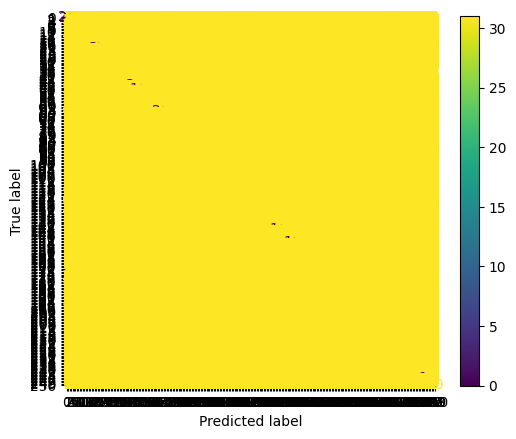

In [94]:
class ml_models(Enum):
    # LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    # KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    # KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    # KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    # KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    # NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]

model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_minus{}".format(model.value[1], chosen_net, layers_to_remove)
    score = model_building(model.value[0], model.value[1], X_train_mobi_n, X_test_mobi_n, y_train, y_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
np.save("./Transfer_Learning/model_metrics/Accuracies_{}_minus{}.npy".format(chosen_net, layers_to_remove), model_accuracies)

In [100]:
model = ml_models.RANDOM_FOREST.value[0]
y_pred = model.predict(X_test_mobi_n)
acc=accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model.classes_)
disp.plot()
plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}_{}.pdf".format(chosen_net.value[2], model_name))
cm = np.array(cm)
np.save("./Transfer_Learning/model_metrics/ConfM_{}:{}.npy".format(chosen_net.value[2], model_name), cm)
with open('./Transfer_Learning/models/{}_{}.pkl'.format(chosen_net.value[2], model_name),'wb') as f:
    pickle.dump(model,f)

Error in callback <function flush_figures at 0x000001B26F65C680> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [101]:
acc

0.0839586459896615